In [12]:
import random as rd
import numpy as np
import scipy as sp

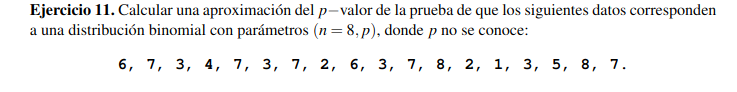

Tenemos una muestra $Y_1, Y_2, \cdots, Y_n$, que toman valores en el conjunto {1, 2, 3, 4, 5, 6, 7, 8}. Y quiero ver si los datos provienen de una variable X ~ Bin(n=8, p) donde no conozco el valor de p.

Si X ~ Bin(n=8, p), entonces:
$$
p_i = P(X = i) = \binom{8}{i} p^i (1-p)^{8-i}
$$

La Esperanza de X estara dada por: $E(X) = np = 8p$. Entonces utilizo el estimador de la media poblacional para estimar p:

In [13]:
data = np.array([6, 7, 3, 4, 7, 3, 7, 2, 6, 3, 7, 8, 2, 1, 3, 5, 8, 7], dtype=float)
print(round(np.mean(data),4))

4.9444


Entonces tengo:
$$
\begin{align*}
E(X) &= 8p \\
4.9444 &= 8p \\
\hat{p} &= 0.618
\end{align*}
$$

Ahora debo agrupar los valores de la muestra junto con sus frecuencias, se debe agrupar tal que la frecuencia es >= 3. Si un unico valor no cumple con la condicion, se debe agrupar con el valor mas cercano y la probabilidad se calculara como P(X > i) o P(X < i) segun corresponda.

In [14]:
values, frec = np.unique(data, return_counts=True)
print(values)
print(frec)

[1. 2. 3. 4. 5. 6. 7. 8.]
[1 2 4 1 1 2 5 2]


Podemos hacer los siguientes grupos:
- los que toman valores menores o iguales a 2. N = 3
- los que toman valor 3, N = 4
- los que toman valores entre 4 y 6, N = 4
- los que toman valores mayores o iguales a 7 N = 7

Ahora debo calcular las siguientes probabilidades utilizando $\hat{p} = 0.618$:
$$
P(X \leq 2) = P(X = 0) + P(X = 1) + P(X = 2) \\
P(X = 3) = \binom{8}{i} p^3 (1-p)^{8-3} \\
P(4 \leq X \leq 6) = P(X = 4) + P(X = 5) + P(X = 6) \\
P(X \geq 7) = 1 - P(X < 7) \\
= 1 - P(X = 0) - P(X = 1) - P(X = 2) - P(X = 3) - P(X = 4) - P(X = 5) - P(X = 6)
$$

Calculo las probabilidades:

In [15]:
n = 8
p_hat = 0.618
print(round(sp.stats.binom.cdf(2, n, p_hat),4))
print(round(sp.stats.binom.pmf(3, n, p_hat),4))
print(round(sp.stats.binom.cdf(6, n, p_hat)-sp.stats.binom.cdf(3, n,p_hat),4))
print(round(1 - sp.stats.binom.cdf(6, n, p_hat),4))

0.0396
0.1075
0.7264
0.1265


Ahora teniendo un estimador para p, las frecuencias y probabilidades para cada agrupamiento, puedo calcular el estadistico de prueba:

In [16]:
def estadistico(n, pi,Ni):
    t = 0
    for i in range(len(Ni)):
        t += ((Ni[i] - n*pi[i])**2)/(n*pi[i])
    return t

def calcular_pvalor_param(t, k, m):
    return 1 - sp.stats.chi2.cdf(t, k-1-m)

In [31]:
n = 18 # TAMAÑO DE LA MUESTRA
Ni = [3.0, 4.0, 4.0, 7.0] # FRECUENCIAS OBSERVADAS
pi = [0.0396, 0.1075, 0.7264, 0.1265] # PROBABILIDADES PARA CADA GRUPO
k = 4 # CANTIDAD DE GRUPOS
m = 1 # PARAMETROS ESTIMADOS

t = estadistico(n, pi, Ni)
print(round(t,4))
print(calcular_pvalor_param(t, k, m))

25.6382
2.7085010531058273e-06


In [32]:
pi_2= [n*i for i in pi]
sp.stats.chisquare(Ni, pi_2, ddof=m)
# chisquare usa la cantidad de grados de libertad como k-1-ddof.
# como estime un parametro paso dd0f=1.

Power_divergenceResult(statistic=25.63823038606894, pvalue=2.70850105310289e-06)

Ahora para hacer una simulacion debo generar N muestras de tamaño 18 y de una Bin(8, 0.618) y calcular un nuevo $\hat{p}_{sim}$ y recalcular el estadistico de prueba.

In [ ]:
def gen_muestra(N, n, p):
    return [sp.stats.binom.rvs(n, p) for i in range(N)]

In [ ]:
def estimar_pvalor(nsims, n, p_hat, pi, Ni):
    t_est = 0
    t = estadistico(n, pi, Ni)
    print(t)
    p_sim = p_hat
    for i in range(nsims):
        Ni_m = [0, 0, 0, 0]
        pi_m = [0, 0, 0, 0]
        muestra = gen_muestra(n, 8, p_sim) # genero una nueva muestra de tamaño n
        for obs in muestra:
            if obs <= 2:
                Ni_m[0] += 1
            elif obs == 3:
                Ni_m[1] += 1
            elif obs <= 6: # entre 4 y 6
                Ni_m[2] += 1
            else: # mayor que 7
                Ni_m[3] += 1
        # Ya tengo las frecuencias de la nueva muestra por grupo, 
        # ahora debo calcular el p_sim
        p_sim = np.mean(muestra)/8 
        # ahora recalculo las probabilidades
        pi_m[0]=round(sp.stats.binom.cdf(2, 8, p_sim),4)
        pi_m[1]=round(sp.stats.binom.pmf(3, 8, p_sim),4)
        pi_m[2]=round(sp.stats.binom.cdf(6, 8, p_sim)-sp.stats.binom.cdf(3, 8,p_sim),4)
        pi_m[3]=round(1 - sp.stats.binom.cdf(6, 8, p_sim),4)
        t1 = estadistico(n, pi_m, Ni_m)  # calculo un nuevo estadistico
        if t1 >= t:
            t_est += 1

    return t_est/nsims

In [ ]:
nsims = 1000
n = 18 # tamaño de la muestra
p_hat = 0.618 # estimador de p con datos iniciales
Ni = [3.0, 4.0, 4.0, 7.0] # frecuencias observadas de muestra inicial
pi = [0.0396, 0.1075, 0.7264, 0.1265] # probabilidades de muestra inicial 
print(estimar_pvalor(nsims, n, p_hat, pi, Ni))

25.63823038606894


/tmp/ipykernel_46389/1861835612.py:4: RuntimeWarning: invalid value encountered in scalar divide
  t += ((Ni[i] - n*pi[i])**2)/(n*pi[i])


0.001
